# ***Analisis Sentimen Pengguna terhadap Aplikasi Belajar Online: Studi Perbandingan Coursera, Ruangguru, edX, Udemy, SoloLearn, dan Simplilearn***

## 1. Import Library

In [1]:
from google_play_scraper import app, reviews, Sort, reviews_all


from tenacity import retry, stop_after_attempt, wait_fixed
import pandas as pd  # Pandas untuk manipulasi dan analisis data
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np  # NumPy untuk komputasi numerik
from io import StringIO
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi

import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Pengumpulan Data

In [2]:
def fetch_and_save_reviews_for_apps(app_ids, file_names, lang='id', country='id', sort=Sort.MOST_RELEVANT, count=10000):
    for app_id, file_name in zip(app_ids, file_names):
        # Ambil ulasan dari Google Play Store
        result, continuation_token = reviews(
            app_id,
            lang=lang,
            country=country,
            sort=sort,
            count=count,
            filter_score_with=None
        )
        
        
        df = pd.DataFrame(np.array(result), columns=['reviews'])
        df = df.join(pd.DataFrame(df.pop('reviews').tolist()))
        
        # Simpan DataFrame ke file Excel
        df.to_excel(file_name, index=False)
        print(f"Saved reviews for {app_id} to {file_name}")

app_ids = [
    'org.coursera.android',
    'com.ruangguru.livestudents',
    'org.edx.mobile',
    'com.udemy.android',
    'com.sololearn',
    'com.mobile.simplilearn'
]

file_names = [
    'coursera.xlsx',
    'ruangguru.xlsx',
    'edx.xlsx',
    'udemy.xlsx',
    'sololearn.xlsx',
    'simplilearn.xlsx'
]

fetch_and_save_reviews_for_apps(app_ids, file_names)

Saved reviews for org.coursera.android to coursera.xlsx
Saved reviews for com.ruangguru.livestudents to ruangguru.xlsx
Saved reviews for org.edx.mobile to edx.xlsx
Saved reviews for com.udemy.android to udemy.xlsx
Saved reviews for com.sololearn to sololearn.xlsx
Saved reviews for com.mobile.simplilearn to simplilearn.xlsx


## 3. Load Data

In [4]:
df_coursera = pd.read_excel('coursera.xlsx')
df_ruangguru = pd.read_excel('ruangguru.xlsx')
df_edx = pd.read_excel('edx.xlsx')
df_udemy = pd.read_excel('udemy.xlsx')
df_sololearn = pd.read_excel('sololearn.xlsx')
df_simplilearn = pd.read_excel('simplilearn.xlsx')

df_coursera['Application'] = 'Coursera'
df_ruangguru['Application'] = 'Ruangguru'
df_edx['Application'] = 'edX'
df_udemy['Application'] = 'Udemy'
df_sololearn['Application'] = 'SoloLearn'
df_simplilearn['Application'] = 'Simplilearn'

In [ ]:
# Menggabungkan semua dataframe
df_combined = pd.concat([df_coursera, df_ruangguru, df_edx, df_udemy, df_sololearn, df_simplilearn], ignore_index=True)
df_combined.to_excel('reviews.xlsx', index=False)

In [4]:
df = pd.read_excel('data/reviews.xlsx')
df

reviewId             userName  \
0      a07cf7fe-05f4-4e0e-868a-7c42a4bc4dcb   April Dian Saputra   
1      2ffb31d2-db93-423a-8efe-eedc3b74b55b        Richie Wijaya   
2      eb086dda-a53c-4fc0-bda7-b782e4b47333  Ayu Setia Wulandari   
3      0d15fe91-1cb8-40c2-8093-82306c42a781      Giri Firmansyah   
4      90237394-92c4-48d4-9d9e-56dbd1d75ce0     sinta hendriyani   
...                                     ...                  ...   
15992  03055c66-9bf1-497d-8e2e-80961db46edb    Nurul Azza Faizah   
15993  e245cbd6-3849-40aa-b66b-9489dcb0855f      Astrid Maharani   
15994  901ed3a2-e0f0-49b1-a173-8725aa0ae2e7        Denny WILLIAM   
15995  0eedda5f-e4b6-4157-85c1-8dd0fdbf08b3        Rifqi Alhabib   
15996  e9f4ecac-c84c-4270-b0de-60eecdcd8bf8                   mm   

                                               userImage  \
0      https://play-lh.googleusercontent.com/a-/ALV-U...   
1      https://play-lh.googleusercontent.com/a-/ALV-U...   
2      https://play-lh.googleusercontent.com/a-/ALV-U...   
3      https://play-lh.googleusercontent.com/a-/ALV-U...   
4      https://play-lh.googleusercontent.com/a/ACg8oc...   
...                                                  ...   
15992  https://play-lh.googleusercontent.com/a-/ALV-U...   
15993  https://play-lh.googleusercontent.com/a/ACg8oc...   
15994  https://play-lh.googleusercontent.com/a-/ALV-U...   
15995  https://play-lh.googleusercontent.com/a/ACg8oc...   
15996  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                                 content  score  \
0      aplikasi nya sdh baik, hanya ada beberapa vide...      4   
1      Aplikasi nya bagus banget bisa menambahkan ilm...      5   
2      Terimakasih karena menjawab keluhan saya dan b...      5   
3      pembayaran harus pakai kartu kredit!! disediak...      2   
4      kursus nya bagus tapi sy ada mengalami kendala...      5   
...                                                  ...    ...   
15992                           thank you for the course      5   
15993                                           great!!!      5   
15994                                             mantab      5   
15995                                              Bagus      5   
15996                                            👍👍👍👍👍 😊      5   

       thumbsUpCount reviewCreatedVersion                  at replyContent  \
0                  2                5.4.0 2024-05-25 06:34:03          NaN   
1                  4                5.7.1 2024-07-01 08:30:01          NaN   
2                  4                5.4.0 2024-05-18 06:52:25          NaN   
3                 13                5.0.0 2024-03-05 09:59:26          NaN   
4                 18                5.2.0 2024-04-06 15:28:10          NaN   
...              ...                  ...                 ...          ...   
15992              0                  NaN 2022-12-31 07:19:03          NaN   
15993              0                  NaN 2023-09-20 14:20:51          NaN   
15994              0                  NaN 2023-08-20 23:56:08          NaN   
15995              0                  NaN 2023-01-05 22:11:58          NaN   
15996              0                  NaN 2022-05-10 09:56:05          NaN   

      repliedAt appVersion  Application  
0           NaT      5.4.0     Coursera  
1           NaT      5.7.1     Coursera  
2           NaT      5.4.0     Coursera  
3           NaT      5.0.0     Coursera  
4           NaT      5.2.0     Coursera  
...         ...        ...          ...  
15992       NaT        NaN  Simplilearn  
15993       NaT        NaN  Simplilearn  
15994       NaT        NaN  Simplilearn  
15995       NaT        NaN  Simplilearn  
15996       NaT        NaN  Simplilearn  

[15997 rows x 12 columns]

## 4. Feature Selection

In [5]:
df = df.loc[:, ['userName', 'content', 'score', 'at', 'Application']]
df.rename(columns={'userName': 'Nama Pengguna', 'content':'Ulasan','score':'Rating','at': 'Waktu','Application':'Aplikasi'}, inplace=True)
df.head()

Nama Pengguna                                             Ulasan  \
0   April Dian Saputra  aplikasi nya sdh baik, hanya ada beberapa vide...   
1        Richie Wijaya  Aplikasi nya bagus banget bisa menambahkan ilm...   
2  Ayu Setia Wulandari  Terimakasih karena menjawab keluhan saya dan b...   
3      Giri Firmansyah  pembayaran harus pakai kartu kredit!! disediak...   
4     sinta hendriyani  kursus nya bagus tapi sy ada mengalami kendala...   

   Rating               Waktu  Aplikasi  
0       4 2024-05-25 06:34:03  Coursera  
1       5 2024-07-01 08:30:01  Coursera  
2       5 2024-05-18 06:52:25  Coursera  
3       2 2024-03-05 09:59:26  Coursera  
4       5 2024-04-06 15:28:10  Coursera

## 5. Pre-processing

In [6]:
df.dropna(inplace=True)
df.isna().sum()

Nama Pengguna    0
Ulasan           0
Rating           0
Waktu            0
Aplikasi         0
dtype: int64

In [7]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [8]:
df.head()

Nama Pengguna                                             Ulasan  \
0   April Dian Saputra  aplikasi nya sdh baik, hanya ada beberapa vide...   
1        Richie Wijaya  Aplikasi nya bagus banget bisa menambahkan ilm...   
2  Ayu Setia Wulandari  Terimakasih karena menjawab keluhan saya dan b...   
3      Giri Firmansyah  pembayaran harus pakai kartu kredit!! disediak...   
4     sinta hendriyani  kursus nya bagus tapi sy ada mengalami kendala...   

   Rating               Waktu  Aplikasi  
0       4 2024-05-25 06:34:03  Coursera  
1       5 2024-07-01 08:30:01  Coursera  
2       5 2024-05-18 06:52:25  Coursera  
3       2 2024-03-05 09:59:26  Coursera  
4       5 2024-04-06 15:28:10  Coursera

In [9]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [10]:
slang_excel = pd.read_excel("data/Slang.xlsx")
slang_from_excel = dict(zip(slang_excel.iloc[:, 0], slang_excel.iloc[:, 1]))
slang_tuple = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
slangwords = {
    'video': 'video',  
    'vidio': 'video',  
    'aku': 'saya',
    'saya': 'saya',
    'gue': 'saya',
    'gua': 'saya',
    'ane': 'saya',
    'me': 'saya',
    'gw': 'saya',
    'apps': 'aplikasi',
    'aplikasinya': 'aplikasi',
    'tutorial': 'cara',
    'tutor': 'cara',
    'plis': 'tolong',
    'pls': 'tolong',
    'dong': 'tolong',
    'coy': 'teman',
    'bro': 'teman',
    'sob': 'teman',
    'nggak': 'tidak',
    'gak': 'tidak',
    'ga': 'tidak',
    'enggak': 'tidak',
    'engga': 'tidak',
    'nonton': 'menonton',
    'liat': 'lihat',
    'lihat': 'lihat',
    'moga': 'semoga',
    'moga2': 'semoga',
    'btw': 'ngomong-ngomong',
    'dpt': 'dapat',
    'dapet': 'dapat',
    'dr': 'dari',
    'dari': 'dari',
    'gmn': 'bagaimana',
    'bgmn': 'bagaimana',
    'km': 'kamu',
    'lo': 'kamu',
    'lu': 'kamu',
    'elo': 'kamu',
    'u': 'kamu',
    'sy': 'saya',
    'kl': 'kalau',
    'klo': 'kalau',
    'klw': 'kalau',
    'krn': 'karena',
    'krna': 'karena',
    'kenapa': 'kenapa',
    'knp': 'kenapa',
    'kalo': 'kalau',
    'kapan': 'kapan',
    'brp': 'berapa',
    'berapa': 'berapa',
    'dah': 'sudah',
    'udah': 'sudah',
    'sdh': 'sudah',
    'pd': 'pada',
    'pada': 'pada',
    'tp': 'tapi',
    'tapi': 'tapi',
    'jg': 'juga',
    'juga': 'juga',
    'org': 'orang',
    'orang': 'orang',
    'temen': 'teman',
    'tmn': 'teman',
    'teman': 'teman',
    'sih': 'sih',
    'aja': 'saja',
    'saja': 'saja',
    'dmn': 'di mana',
    'dimana': 'di mana',
    'knpa': 'kenapa',
    'krn': 'karena',
    'sbnr': 'sebenarnya',
    'msh': 'masih',
    'masih': 'masih',
    'tgl': 'tanggal',
    'tanggal': 'tanggal',
    'blm': 'belum',
    'belum': 'belum',
}
all_slangwords = {**slang_tuple, **slang_from_excel, **slangwords}
all_slangwords = pd.DataFrame(list(all_slangwords.items()), columns=['Slang', 'Standard'])
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in all_slangwords:
            fixed_words.append(all_slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [11]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['Ulasan'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [12]:
df.head()

Nama Pengguna                                             Ulasan  \
0   April Dian Saputra  aplikasi nya sdh baik, hanya ada beberapa vide...   
1        Richie Wijaya  Aplikasi nya bagus banget bisa menambahkan ilm...   
2  Ayu Setia Wulandari  Terimakasih karena menjawab keluhan saya dan b...   
3      Giri Firmansyah  pembayaran harus pakai kartu kredit!! disediak...   
4     sinta hendriyani  kursus nya bagus tapi sy ada mengalami kendala...   

   Rating               Waktu  Aplikasi  \
0       4 2024-05-25 06:34:03  Coursera   
1       5 2024-07-01 08:30:01  Coursera   
2       5 2024-05-18 06:52:25  Coursera   
3       2 2024-03-05 09:59:26  Coursera   
4       5 2024-04-06 15:28:10  Coursera   

                                          text_clean  \
0  aplikasi nya sdh baik hanya ada beberapa video...   
1  Aplikasi nya bagus banget bisa menambahkan ilm...   
2  Terimakasih karena menjawab keluhan saya dan b...   
3  pembayaran harus pakai kartu kredit disediakan...   
4  kursus nya bagus tapi sy ada mengalami kendala...   

                                text_casefoldingText  \
0  aplikasi nya sdh baik hanya ada beberapa video...   
1  aplikasi nya bagus banget bisa menambahkan ilm...   
2  terimakasih karena menjawab keluhan saya dan b...   
3  pembayaran harus pakai kartu kredit disediakan...   
4  kursus nya bagus tapi sy ada mengalami kendala...   

                                     text_slangwords  \
0  aplikasi nya sdh baik hanya ada beberapa video...   
1  aplikasi nya bagus banget bisa menambahkan ilm...   
2  terimakasih karena menjawab keluhan saya dan b...   
3  pembayaran harus pakai kartu kredit disediakan...   
4  kursus nya bagus tapi sy ada mengalami kendala...   

                                 text_tokenizingText  \
0  [aplikasi, nya, sdh, baik, hanya, ada, beberap...   
1  [aplikasi, nya, bagus, banget, bisa, menambahk...   
2  [terimakasih, karena, menjawab, keluhan, saya,...   
3  [pembayaran, harus, pakai, kartu, kredit, dise...   
4  [kursus, nya, bagus, tapi, sy, ada, mengalami,...   

                                       text_stopword  \
0  [aplikasi, sdh, video, pembelajaran, bermasala...   
1  [aplikasi, bagus, banget, ilmu, yng, butuh, po...   
2  [terimakasih, keluhan, berbaik, hati, memperba...   
3  [pembayaran, pakai, kartu, kredit, disediakan,...   
4  [kursus, bagus, sy, mengalami, kendala, quiz, ...   

                                          text_akhir  
0  aplikasi sdh video pembelajaran bermasalah ter...  
1  aplikasi bagus banget ilmu yng butuh pokonya a...  
2  terimakasih keluhan berbaik hati memperbaikiny...  
3  pembayaran pakai kartu kredit disediakan pay p...  
4  kursus bagus sy mengalami kendala quiz option ...

## 6.Labeling

In [13]:
import csv
import requests
from io import StringIO
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [14]:
# Function to determine sentiment polarity of tweets
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score >= 0):
        polarity = 'positif'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negatif'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    # else:
    #     polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [15]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
positif    11492
negatif     4197
Name: count, dtype: int64


## 7.TF-IDF (Term Frequency-Inverse Document Frequency)

In [16]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = df['text_akhir']
y = df['polarity']
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

academy  add  aja  alhamdulillah  anak  animasi  animasinya  apk  \
0          0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
1          0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
2          0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
3          0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
4          0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
...        ...  ...  ...            ...   ...      ...         ...  ...   
15684      0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
15685      0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
15686      0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
15687      0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   
15688      0.0  0.0  0.0            0.0   0.0      0.0         0.0  0.0   

       aplikasi  aplikasinya  ...  trus  tuh  udah  udh  ulangan  update  \
0      0.324474          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
1      0.462639          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
2      0.000000          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
3      0.000000          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
4      0.000000          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
...         ...          ...  ...   ...  ...   ...  ...      ...     ...   
15684  0.000000          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
15685  0.000000          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
15686  0.000000          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
15687  0.000000          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   
15688  0.000000          0.0  ...   0.0  0.0   0.0  0.0      0.0     0.0   

         video  videonya  vidio   yg  
0      0.42581       0.0    0.0  0.0  
1      0.00000       0.0    0.0  0.0  
2      0.00000       0.0    0.0  0.0  
3      0.00000       0.0    0.0  0.0  
4      0.00000       0.0    0.0  0.0  
...        ...       ...    ...  ...  
15684  0.00000       0.0    0.0  0.0  
15685  0.00000       0.0    0.0  0.0  
15686  0.00000       0.0    0.0  0.0  
15687  0.00000       0.0    0.0  0.0  
15688  0.00000       0.0    0.0  0.0  

[15689 rows x 200 columns]

## 8.Data Splitting

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [18]:
df.to_excel('data/hasil.xlsx', index=False)

## 9.Modeling and Evaluation

### ***Perbandingan Algoritma Naive Bayes, Support Vector Machine, Decision Tree, Logistic Regression,K-Nearest Neighbors, dan xgboost***

#### Navie Bayes

In [18]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB()

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi
print('Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Naive Bayes - accuracy_test:', accuracy_test_nb)

Naive Bayes - accuracy_train: 0.8018575851393189
Naive Bayes - accuracy_test: 0.7981729339281921


In [19]:
# Matriks kebingungan dan laporan klasifikasi untuk data test
conf_matrix = confusion_matrix(y_test, y_pred_test_nb)
class_report = classification_report(y_test, y_pred_test_nb)

# Output hasil
print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

Confusion Matrix:
[[ 746  550]
 [ 400 3011]]

Classification Report:
              precision    recall  f1-score   support

     negatif       0.65      0.58      0.61      1296
     positif       0.85      0.88      0.86      3411

    accuracy                           0.80      4707
   macro avg       0.75      0.73      0.74      4707
weighted avg       0.79      0.80      0.79      4707



#### Support Vector Machine

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Membuat objek model SVM
svm = SVC()

# Melatih model SVM pada data pelatihan
svm.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

# Evaluasi akurasi model SVM
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.9475505372427608
SVM - accuracy_test: 0.8661567877629063


In [21]:
# Matriks kebingungan dan laporan klasifikasi untuk data test
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)
class_report_svm = classification_report(y_test, y_pred_test_svm)

# Output hasil
print('Confusion Matrix:')
print(conf_matrix_svm)
print('\nClassification Report:')
print(class_report_svm)

Confusion Matrix:
[[ 860  436]
 [ 194 3217]]

Classification Report:
              precision    recall  f1-score   support

     negatif       0.82      0.66      0.73      1296
     positif       0.88      0.94      0.91      3411

    accuracy                           0.87      4707
   macro avg       0.85      0.80      0.82      4707
weighted avg       0.86      0.87      0.86      4707



#### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Membuat objek model Decision Tree
decision_tree = DecisionTreeClassifier()

# Melatih model Decision Tree pada data pelatihan
decision_tree.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_dt = decision_tree.predict(X_train.toarray())
y_pred_test_dt = decision_tree.predict(X_test.toarray())

# Evaluasi akurasi model Decision Tree
accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)

# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Decision Tree - accuracy_train: 0.98825350573666
Decision Tree - accuracy_test: 0.7860633099638836


In [23]:
conf_matrix_dt = confusion_matrix(y_test, y_pred_test_dt)
class_report_dt = classification_report(y_test, y_pred_test_dt)

# Output hasil
print('Confusion Matrix:')
print(conf_matrix_dt)
print('\nClassification Report:')
print(class_report_dt)

Confusion Matrix:
[[ 770  526]
 [ 481 2930]]

Classification Report:
              precision    recall  f1-score   support

     negatif       0.62      0.59      0.60      1296
     positif       0.85      0.86      0.85      3411

    accuracy                           0.79      4707
   macro avg       0.73      0.73      0.73      4707
weighted avg       0.78      0.79      0.78      4707



#### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.886177381169186
Logistic Regression - accuracy_test: 0.8721053749734438


In [25]:
conf_matrix_lr = confusion_matrix(y_test, y_pred_test_lr)
class_report_lr = classification_report(y_test, y_pred_test_lr)

# Output hasil
print('Confusion Matrix:')
print(conf_matrix_lr)
print('\nClassification Report:')
print(class_report_lr)

Confusion Matrix:
[[ 863  433]
 [ 169 3242]]

Classification Report:
              precision    recall  f1-score   support

     negatif       0.84      0.67      0.74      1296
     positif       0.88      0.95      0.92      3411

    accuracy                           0.87      4707
   macro avg       0.86      0.81      0.83      4707
weighted avg       0.87      0.87      0.87      4707



#### K-Nearest Neighbors

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Membuat objek model K-Nearest Neighbors
knn = KNeighborsClassifier()

# Melatih model K-Nearest Neighbors pada data pelatihan
knn.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_knn = knn.predict(X_train.toarray())
y_pred_test_knn = knn.predict(X_test.toarray())

# Evaluasi akurasi model K-Nearest Neighbors pada data pelatihan
accuracy_train_knn = accuracy_score(y_pred_train_knn, y_train)

# Evaluasi akurasi model K-Nearest Neighbors pada data uji
accuracy_test_knn = accuracy_score(y_pred_test_knn, y_test)

# Menampilkan akurasi
print('K-Nearest Neighbors - accuracy_train:', accuracy_train_knn)
print('K-Nearest Neighbors - accuracy_test:', accuracy_test_knn)

K-Nearest Neighbors - accuracy_train: 0.8601347659806957
K-Nearest Neighbors - accuracy_test: 0.805183768854897


In [28]:
conf_matrix_knn = confusion_matrix(y_test, y_pred_test_knn)
class_report_knn = classification_report(y_test, y_pred_test_knn)

# Output hasil
print('Confusion Matrix:')
print(conf_matrix_knn)
print('\nClassification Report:')
print(class_report_knn)

Confusion Matrix:
[[ 657  639]
 [ 278 3133]]

Classification Report:
              precision    recall  f1-score   support

     negatif       0.70      0.51      0.59      1296
     positif       0.83      0.92      0.87      3411

    accuracy                           0.81      4707
   macro avg       0.77      0.71      0.73      4707
weighted avg       0.80      0.81      0.79      4707



#### Xgboost

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Membuat objek LabelEncoder
label_encoder = LabelEncoder()

# Mengonversi label teks menjadi numerik
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Membuat objek model XGBoost
xgb = XGBClassifier()

# Melatih model XGBoost pada data pelatihan yang sudah diencode
xgb.fit(X_train.toarray(), y_train_encoded)

# Prediksi sentimen pada data pelatihan dan data uji menggunakan model XGBoost
y_pred_train_xgb = xgb.predict(X_train.toarray())
y_pred_test_xgb = xgb.predict(X_test.toarray())

# Evaluasi akurasi model XGBoost pada data pelatihan
accuracy_train_xgb = accuracy_score(y_pred_train_xgb, y_train_encoded)

# Evaluasi akurasi model XGBoost pada data uji
accuracy_test_xgb = accuracy_score(y_pred_test_xgb, y_test_encoded)

# Menampilkan akurasi
print('XGBoost - accuracy_train:', accuracy_train_xgb)
print('XGBoost - accuracy_test:', accuracy_test_xgb)


XGBoost - accuracy_train: 0.9439082134401748
XGBoost - accuracy_test: 0.8508604206500956


In [30]:
conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_test_xgb)

# Menghitung classification report untuk model XGBoost
class_report_xgb = classification_report(y_test_encoded, y_pred_test_xgb)

# Output hasil
print('Confusion Matrix for XGBoost:')
print(conf_matrix_xgb)
print('\nClassification Report for XGBoost:')
print(class_report_xgb)

Confusion Matrix for XGBoost:
[[ 828  468]
 [ 234 3177]]

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1296
           1       0.87      0.93      0.90      3411

    accuracy                           0.85      4707
   macro avg       0.83      0.79      0.80      4707
weighted avg       0.85      0.85      0.85      4707



In [31]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Logistic Regression', 'K-Nearest Neighbors','XGBoost'],
    'Accuracy Train': [accuracy_train_nb, accuracy_train_svm, accuracy_train_dt, accuracy_train_lr, accuracy_train_knn, accuracy_train_xgb],
    'Accuracy Test': [accuracy_test_nb, accuracy_test_svm, accuracy_test_dt, accuracy_test_lr, accuracy_test_knn,accuracy_test_xgb]
})

# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model', 'Accuracy Test']]
accuracy_train_only = results_df[['Model', 'Accuracy Train']]
# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Mengurutkan DataFrame berdasarkan kolom "Accuracy Train" dari tertinggi ke terendah
accuracy_train_sorted = accuracy_train_only.sort_values(by='Accuracy Train', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print("Accuracy Test Sorted:")
print(accuracy_test_sorted)
print("====================||====================")
print("Accuracy Train Sorted:")
print(accuracy_train_sorted)

Accuracy Test Sorted:
                    Model  Accuracy Test
3     Logistic Regression       0.872105
1  Support Vector Machine       0.866157
5                 XGBoost       0.850860
4     K-Nearest Neighbors       0.805184
0             Naive Bayes       0.798173
2           Decision Tree       0.786063
====================||====================
Accuracy Train Sorted:
                    Model  Accuracy Train
2           Decision Tree        0.988254
1  Support Vector Machine        0.947551
5                 XGBoost        0.943908
3     Logistic Regression        0.886177
4     K-Nearest Neighbors        0.860135
0             Naive Bayes        0.801858


## 10.Visualization

### Keseluruhan

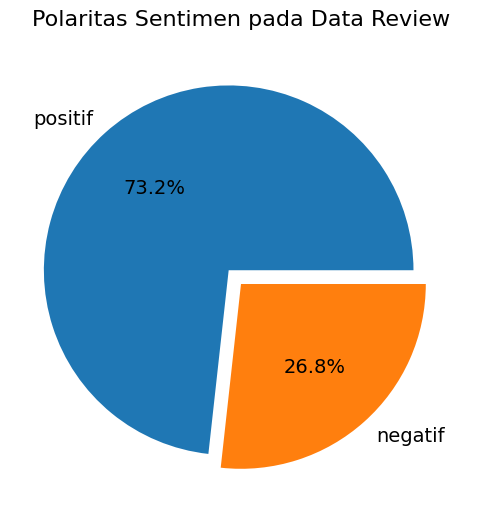

In [32]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df' dan menyimpannya dalam list 'labels'.
labels = list(df['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = (0.1, 0)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Polaritas Sentimen pada Data Review', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

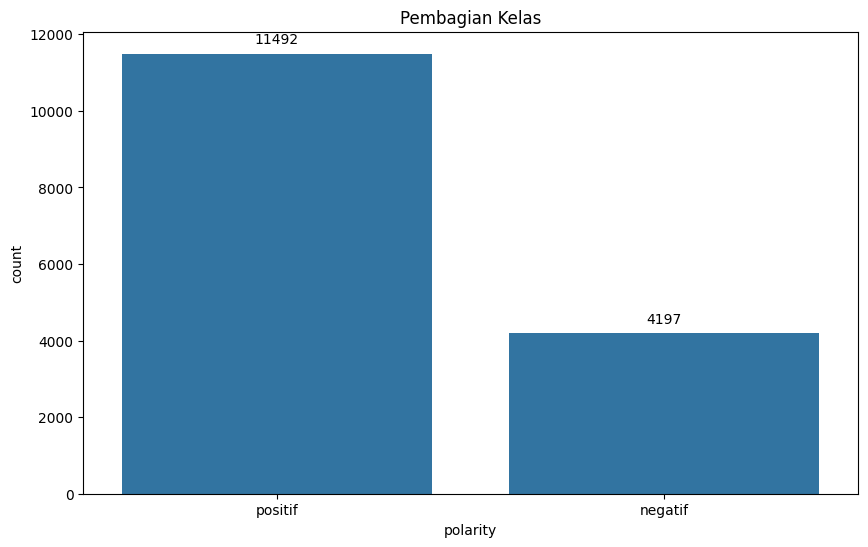

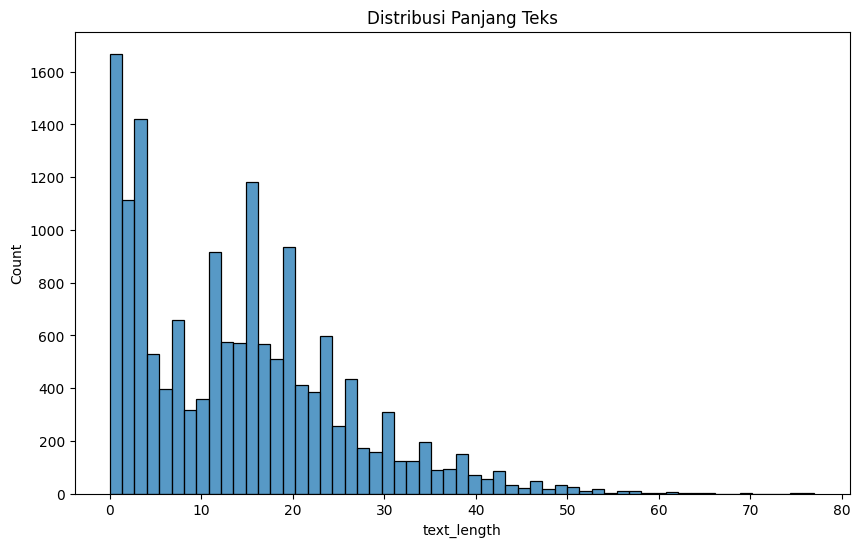

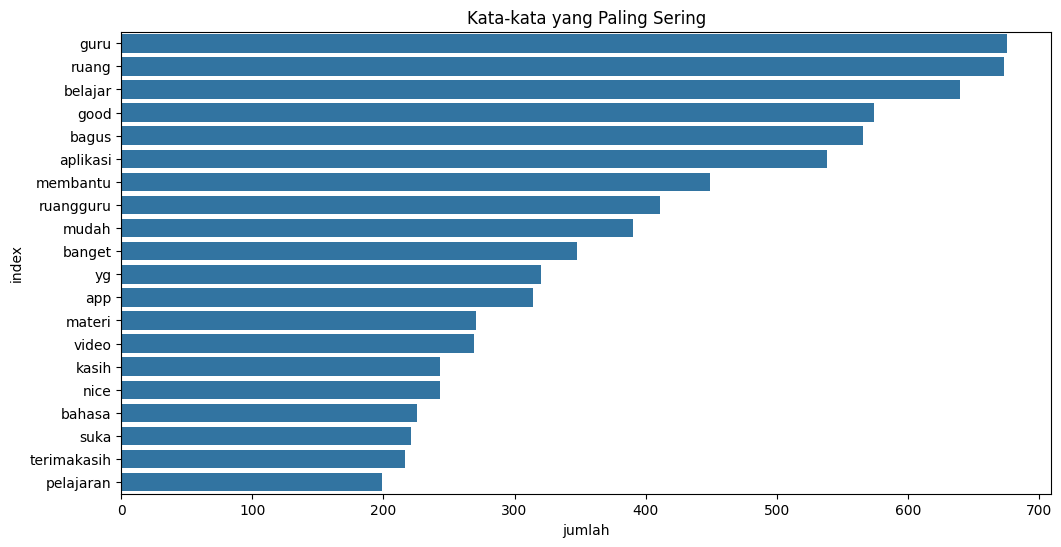

In [33]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Check class distribution
class_dist_plot = sns.countplot(x='polarity', data=df)
plt.title('Pembagian Kelas')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize text length distribution
df['text_length'] = df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'])
plt.title('Distribusi Panjang Teks')
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata-kata yang Paling Sering')
plt.show()

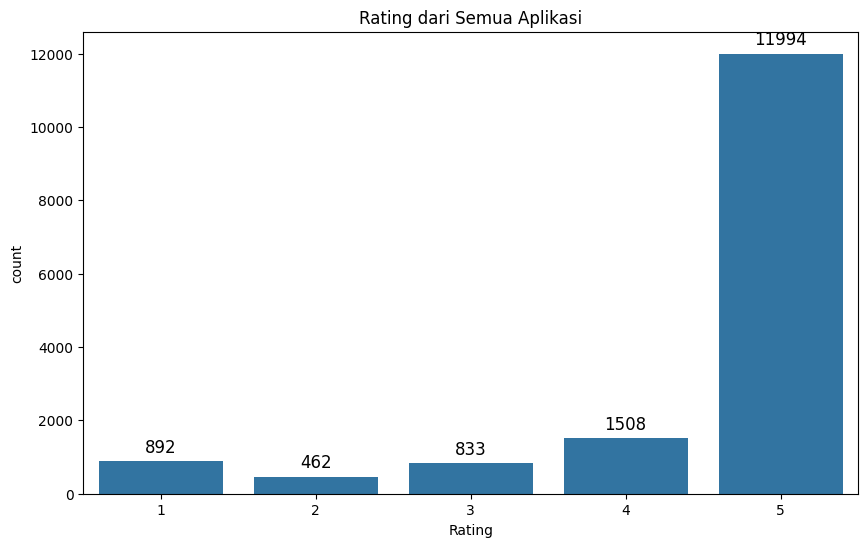

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=df)

# Menambahkan angka di atas setiap batang
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                       textcoords='offset points')

# Menambahkan judul
plt.title('Rating dari Semua Aplikasi')

# Menampilkan plot
plt.show()


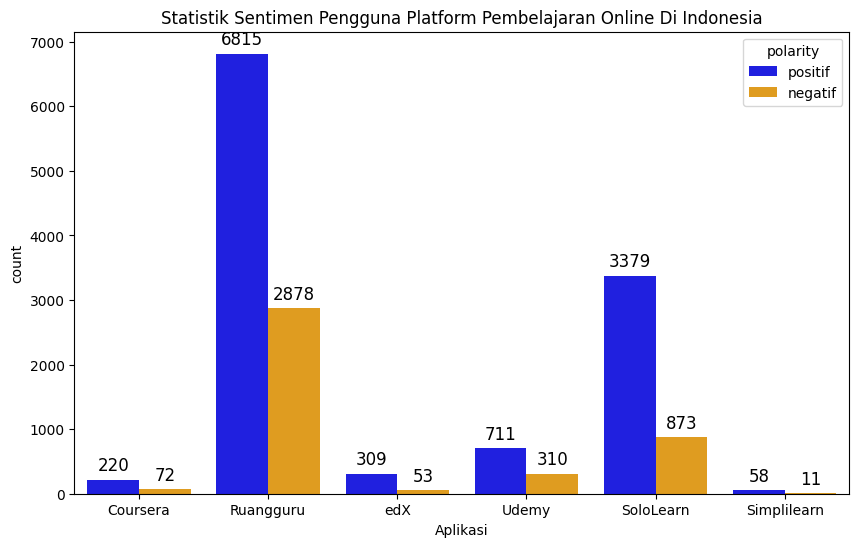

In [35]:
plt.figure(figsize=(10, 6))

# Membuat plot countplot
ax = sns.countplot(x='Aplikasi', hue='polarity', data=df, palette={'positif': 'blue', 'negatif': 'orange'})

# Menambahkan angka di atas setiap batang
for p in ax.patches:
    height = p.get_height()
    if height > 0: # Memastikan label hanya ditambahkan jika tinggi batang lebih dari 0
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                    textcoords='offset points')

# Menambahkan judul
plt.title('Statistik Sentimen Pengguna Platform Pembelajaran Online Di Indonesia')

# Menampilkan plot
plt.show()

### Setiap Aplikasi 

#### 1.Coursera

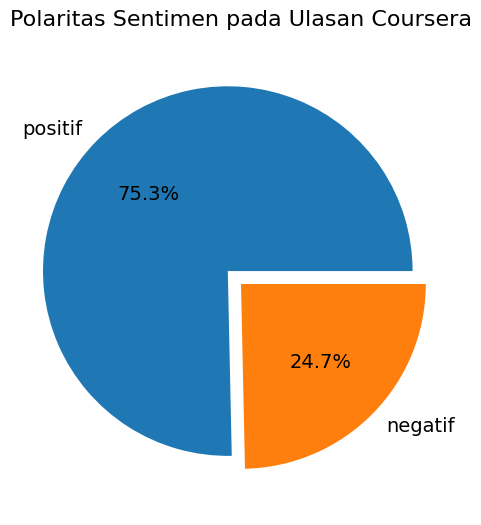

In [36]:
df_coursera = df[df['Aplikasi'] == 'Coursera']
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df_coursera' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df_coursera['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df_coursera' dan menyimpannya dalam list 'labels'.
labels = list(df_coursera['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = [0.1] + [0] * (len(sizes) - 1)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Polaritas Sentimen pada Ulasan Coursera', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

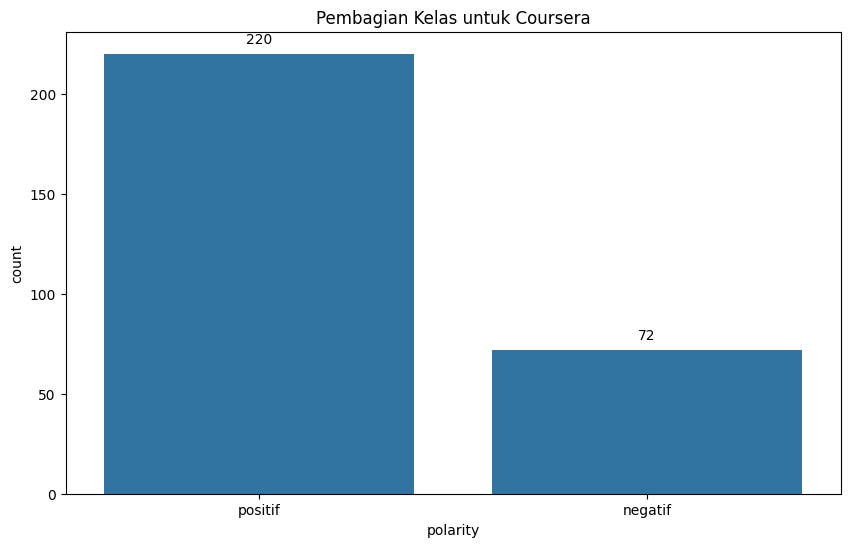

In [37]:
plt.figure(figsize=(10, 6))

# Plot class distribution for Coursera
class_dist_plot = sns.countplot(x='polarity', data=df_coursera)
plt.title('Pembagian Kelas untuk Coursera')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

# Show the plot
plt.show()

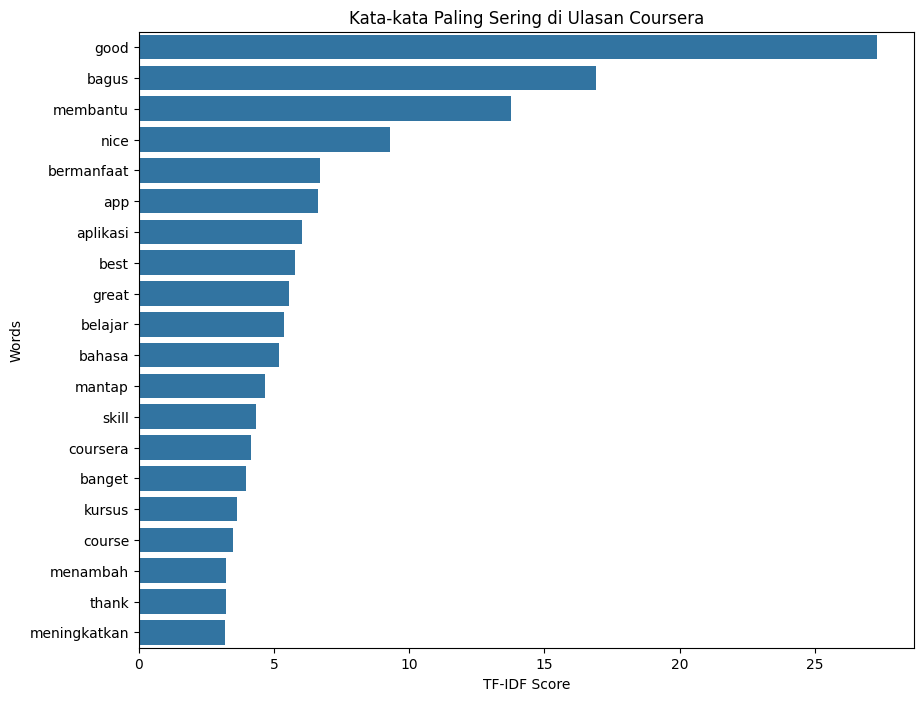

In [38]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_coursera['text_akhir'])

# Convert to DataFrame and sum up the TF-IDF scores for each word
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')

# Sort by the most frequent words and take the top 20
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Plot the most frequent words
plt.figure(figsize=(10, 8))
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata-kata Paling Sering di Ulasan Coursera')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

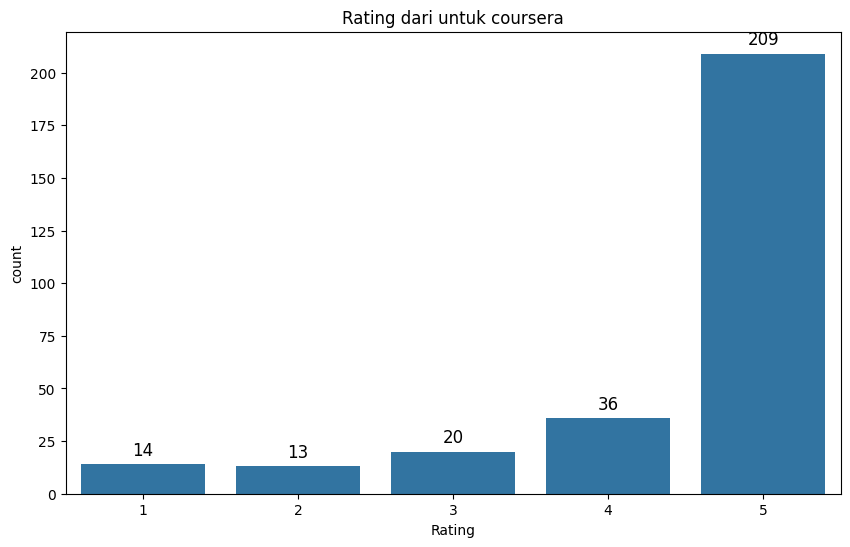

In [39]:
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=df_coursera)

# Menambahkan angka di atas setiap batang
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                       textcoords='offset points')

# Menambahkan judul
plt.title('Rating dari untuk coursera')

# Menampilkan plot
plt.show()

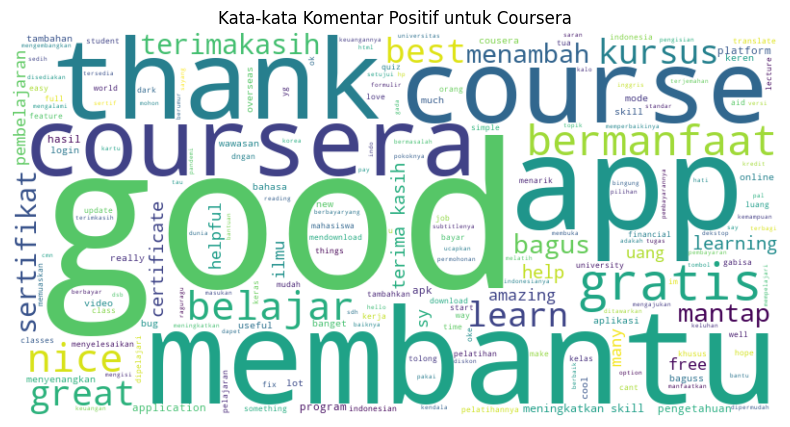

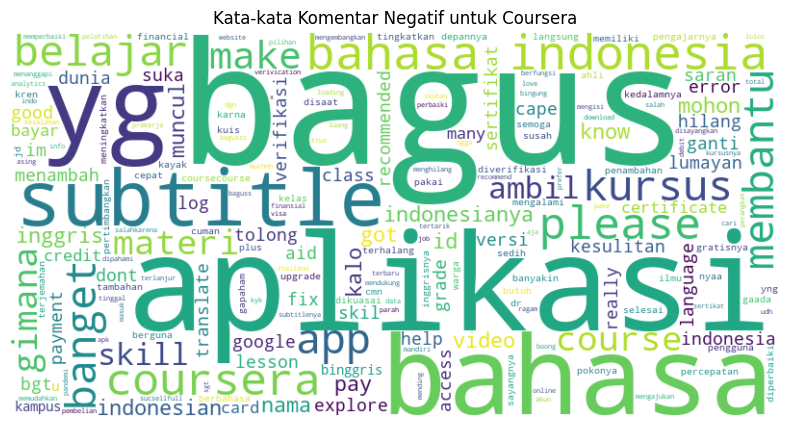

In [40]:
# Nama kolom teks dan polaritas
text_column = 'text_akhir'
polarity_column = 'polarity'
app = 'coursera'

df_coursera = df[df['Aplikasi'].str.lower() == app.lower()]
if text_column in df_coursera.columns and polarity_column in df_coursera.columns:
    # Filter teks positif dan negatif
    positive_texts = " ".join(df_coursera[df_coursera[polarity_column] == 'positif'][text_column].tolist())
    negative_texts = " ".join(df_coursera[df_coursera[polarity_column] == 'negatif'][text_column].tolist())

    # Membuat word cloud untuk teks positif
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Kata-kata Komentar Positif untuk Coursera')
    plt.axis('off')
    plt.show()

    # Membuat word cloud untuk teks negatif
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Kata-kata Komentar Negatif untuk Coursera')
    plt.axis('off')
    plt.show()

#### 2.Ruang Guru

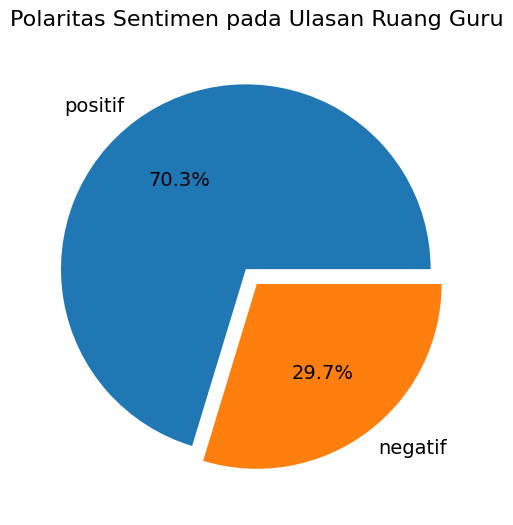

In [41]:
df_ruangguru = df[df['Aplikasi'] == 'Ruangguru']
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df_coursera' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df_ruangguru['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df_ruangguru' dan menyimpannya dalam list 'labels'.
labels = list(df_ruangguru['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = [0.1] + [0] * (len(sizes) - 1)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Polaritas Sentimen pada Ulasan Ruang Guru', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

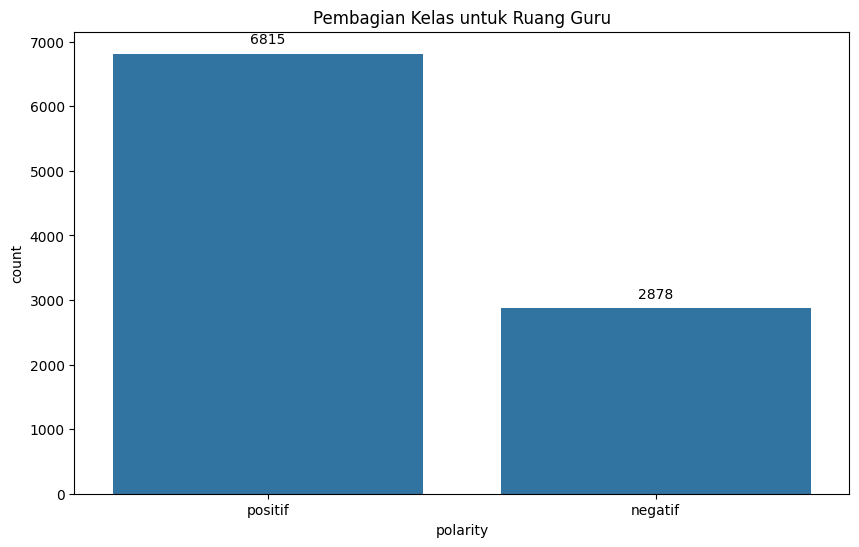

In [42]:
plt.figure(figsize=(10, 6))

# Plot class distribution for Ruang Guru
class_dist_plot = sns.countplot(x='polarity', data=df_ruangguru)
plt.title('Pembagian Kelas untuk Ruang Guru')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

# Show the plot
plt.show()

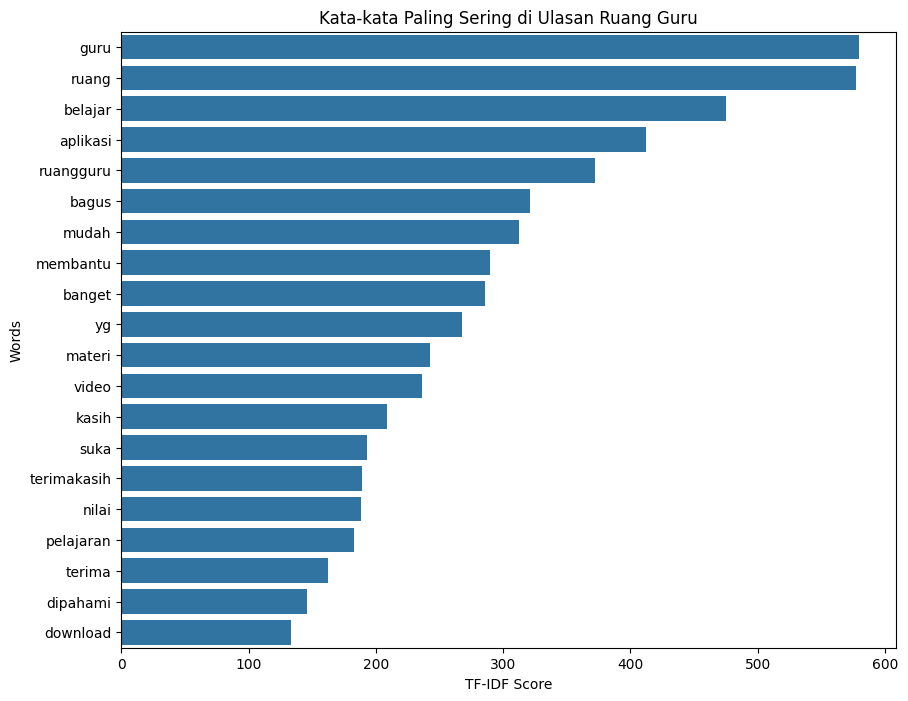

In [43]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_ruangguru['text_akhir'])

# Convert to DataFrame and sum up the TF-IDF scores for each word
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')

# Sort by the most frequent words and take the top 20
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Plot the most frequent words
plt.figure(figsize=(10, 8))
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata-kata Paling Sering di Ulasan Ruang Guru')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

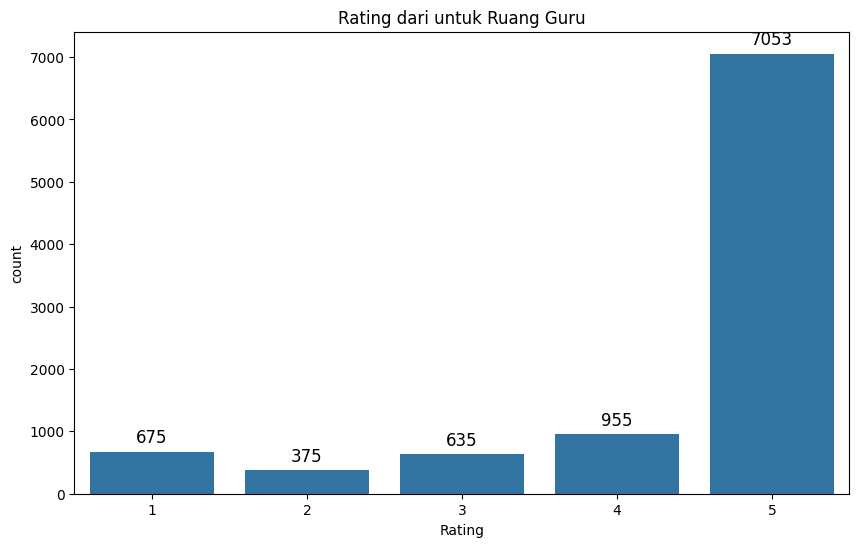

In [44]:
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=df_ruangguru)

# Menambahkan angka di atas setiap batang
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                       textcoords='offset points')

# Menambahkan judul
plt.title('Rating dari untuk Ruang Guru')

# Menampilkan plot
plt.show()

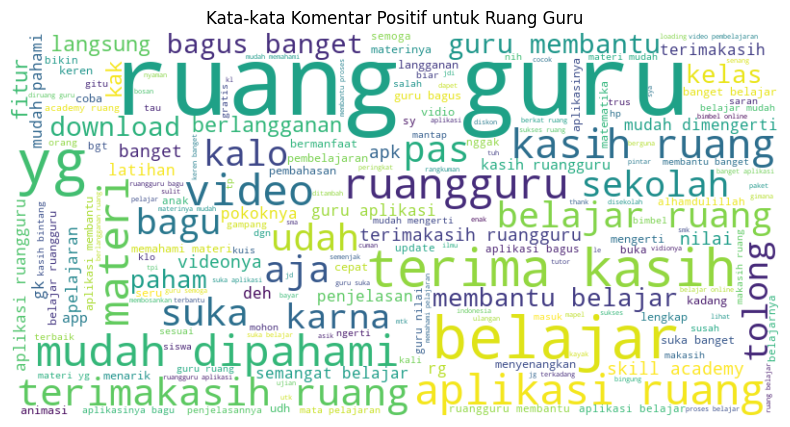

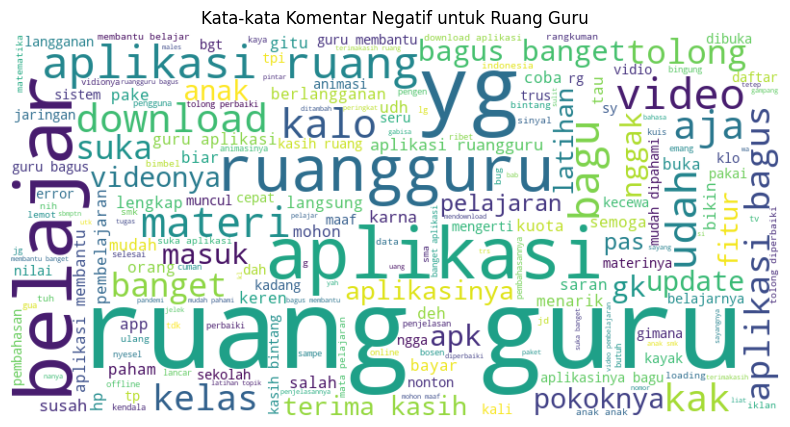

In [45]:
# Nama kolom teks dan polaritas
text_column = 'text_akhir'
polarity_column = 'polarity'
app = 'Ruangguru'
df_ruangguru = df[df['Aplikasi'].str.lower() == app.lower()]
if text_column in df_ruangguru.columns and polarity_column in df_ruangguru.columns:
    # Filter teks positif dan negatif
    positive_texts = " ".join(df_ruangguru[df_ruangguru[polarity_column] == 'positif'][text_column].tolist())
    negative_texts = " ".join(df_ruangguru[df_ruangguru[polarity_column] == 'negatif'][text_column].tolist())

    # Membuat word cloud untuk teks positif
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Kata-kata Komentar Positif untuk Ruang Guru')
    plt.axis('off')
    plt.show()

    # Membuat word cloud untuk teks negatif
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Kata-kata Komentar Negatif untuk Ruang Guru')
    plt.axis('off')
    plt.show()

#### 3.edX

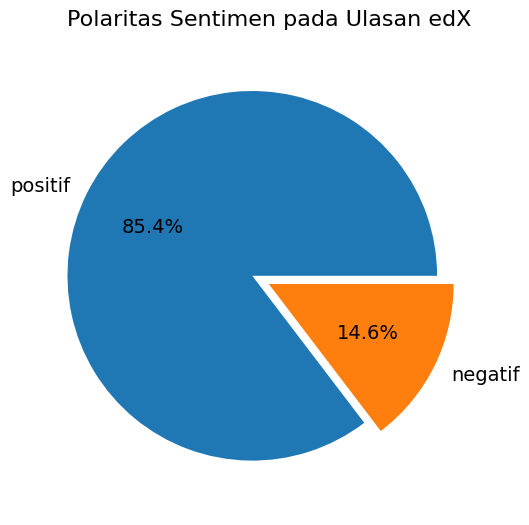

In [46]:
df_edx = df[df['Aplikasi'] == 'edX']
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df_coursera' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df_edx['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df_edx' dan menyimpannya dalam list 'labels'.
labels = list(df_edx['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = [0.1] + [0] * (len(sizes) - 1)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Polaritas Sentimen pada Ulasan edX', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

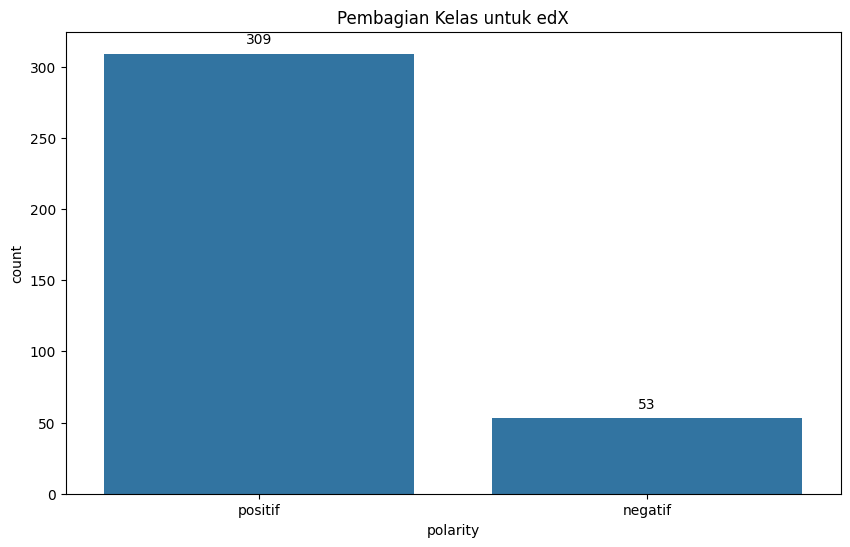

In [47]:
plt.figure(figsize=(10, 6))

# Plot class distribution for Ruang Guru
class_dist_plot = sns.countplot(x='polarity', data=df_edx)
plt.title('Pembagian Kelas untuk edX')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

# Show the plot
plt.show()

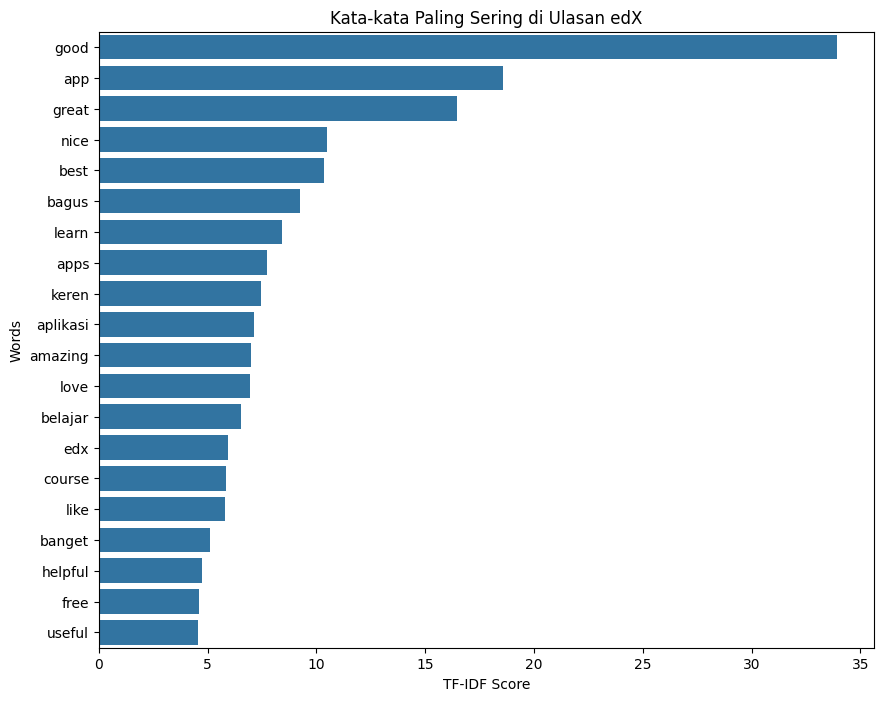

In [48]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_edx['text_akhir'])

# Convert to DataFrame and sum up the TF-IDF scores for each word
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')

# Sort by the most frequent words and take the top 20
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Plot the most frequent words
plt.figure(figsize=(10, 8))
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata-kata Paling Sering di Ulasan edX')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

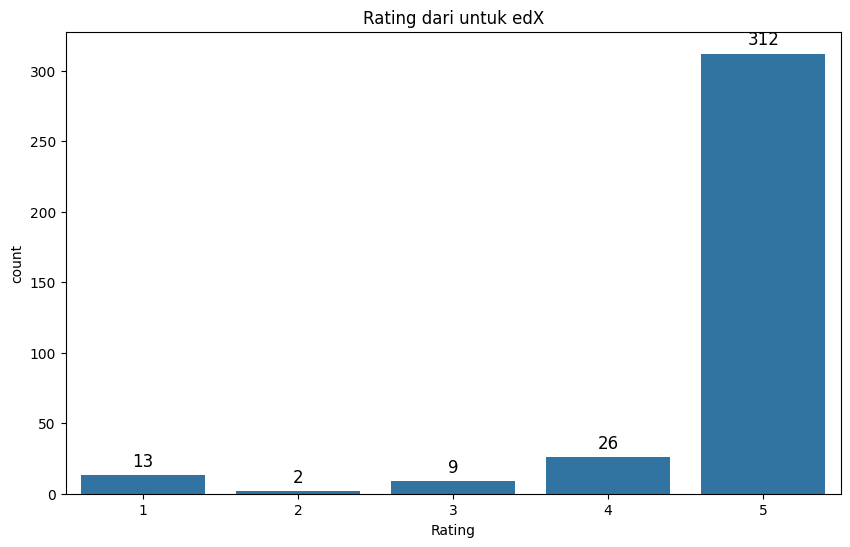

In [49]:
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=df_edx)

# Menambahkan angka di atas setiap batang
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                       textcoords='offset points')

# Menambahkan judul
plt.title('Rating dari untuk edX')

# Menampilkan plot
plt.show()

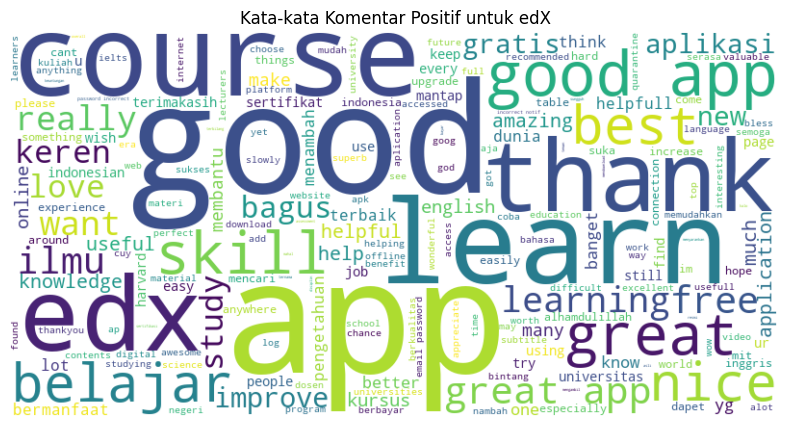

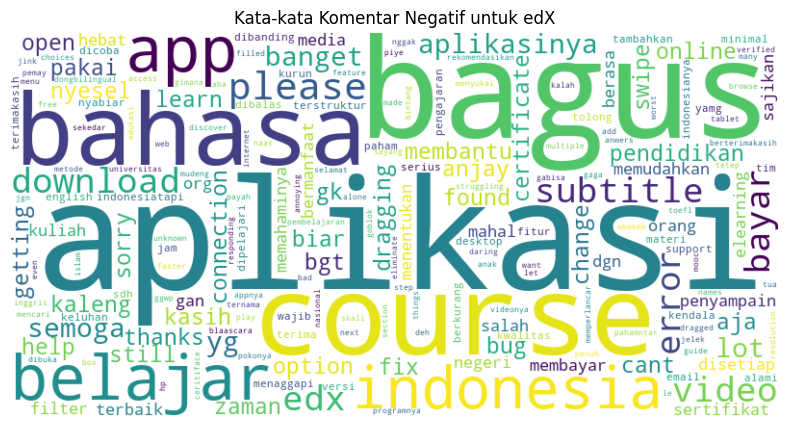

In [50]:
# Nama kolom teks dan polaritas
text_column = 'text_akhir'
polarity_column = 'polarity'
app = 'edX'
df_edx = df[df['Aplikasi'].str.lower() == app.lower()]
if text_column in df_edx.columns and polarity_column in df_edx.columns:
    # Filter teks positif dan negatif
    positive_texts = " ".join(df_edx[df_edx[polarity_column] == 'positif'][text_column].tolist())
    negative_texts = " ".join(df_edx[df_edx[polarity_column] == 'negatif'][text_column].tolist())

    # Membuat word cloud untuk teks positif
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Kata-kata Komentar Positif untuk edX')
    plt.axis('off')
    plt.show()

    # Membuat word cloud untuk teks negatif
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Kata-kata Komentar Negatif untuk edX')
    plt.axis('off')
    plt.show()

#### 4.Udemy

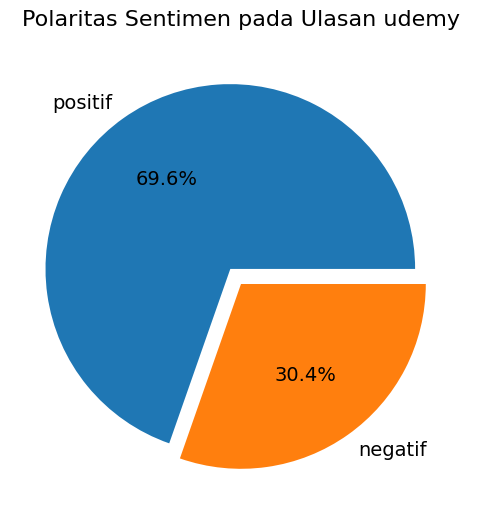

In [51]:
df_udemy = df[df['Aplikasi'] == 'Udemy']
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df_coursera' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df_udemy['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df_udemy' dan menyimpannya dalam list 'labels'.
labels = list(df_udemy['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = [0.1] + [0] * (len(sizes) - 1)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Polaritas Sentimen pada Ulasan udemy', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

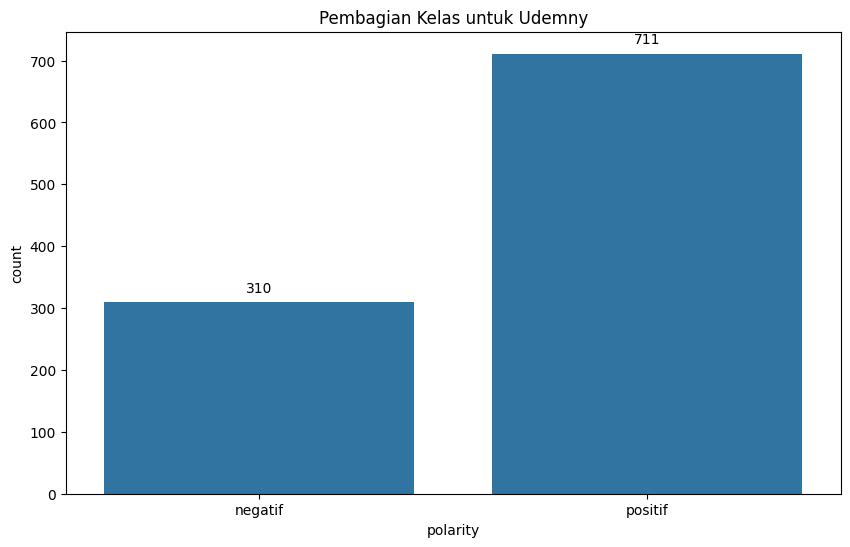

In [52]:
plt.figure(figsize=(10, 6))

# Plot class distribution for Ruang Guru
class_dist_plot = sns.countplot(x='polarity', data=df_udemy)
plt.title('Pembagian Kelas untuk Udemny')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

# Show the plot
plt.show()

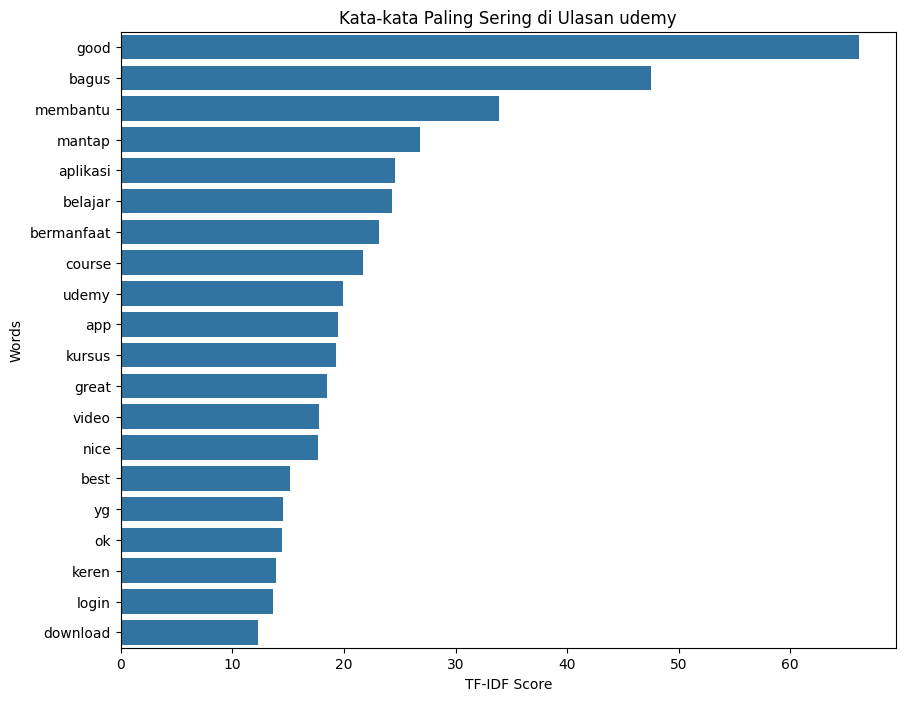

In [53]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_udemy['text_akhir'])

# Convert to DataFrame and sum up the TF-IDF scores for each word
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')

# Sort by the most frequent words and take the top 20
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Plot the most frequent words
plt.figure(figsize=(10, 8))
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata-kata Paling Sering di Ulasan udemy')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

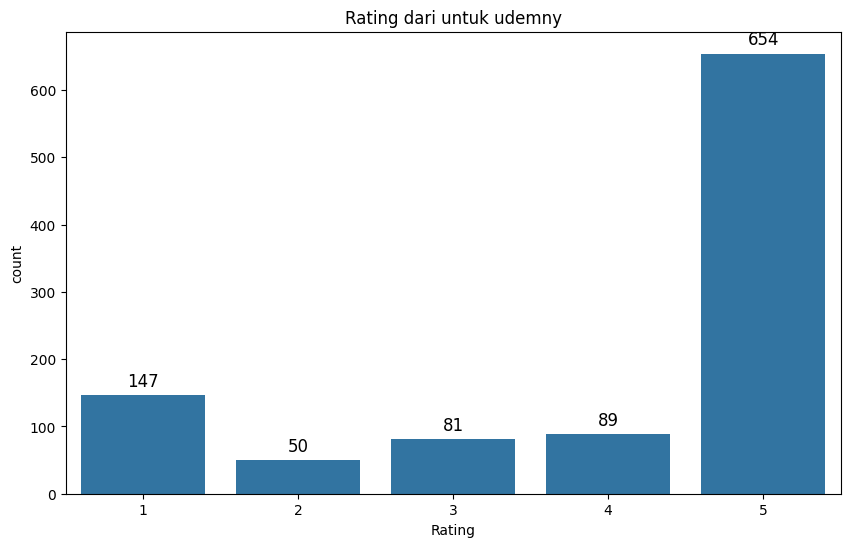

In [54]:
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=df_udemy)

# Menambahkan angka di atas setiap batang
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                       textcoords='offset points')

# Menambahkan judul
plt.title('Rating dari untuk udemny')

# Menampilkan plot
plt.show()

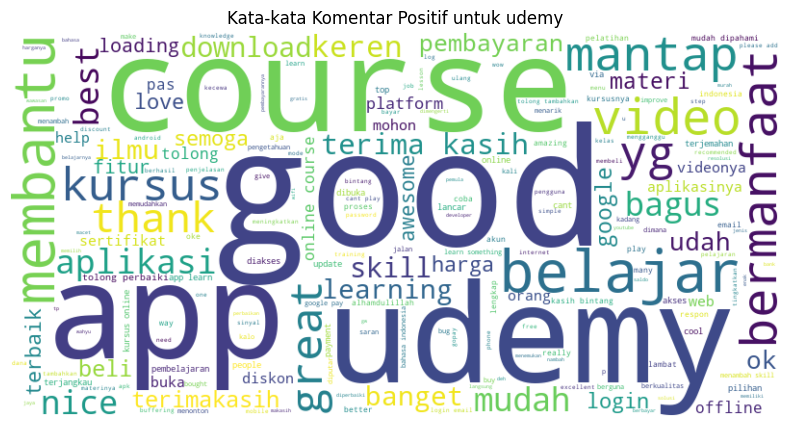

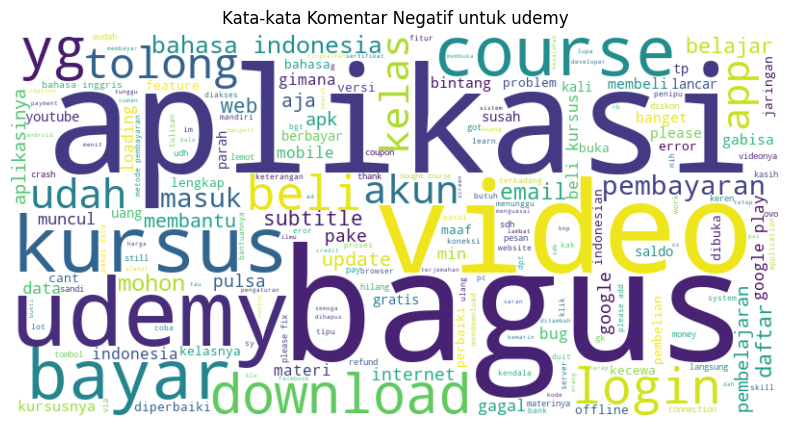

In [55]:
# Nama kolom teks dan polaritas
text_column = 'text_akhir'
polarity_column = 'polarity'
app = 'udemy'
df_udemy = df[df['Aplikasi'].str.lower() == app.lower()]
if text_column in df_udemy.columns and polarity_column in df_udemy.columns:
    # Filter teks positif dan negatif
    positive_texts = " ".join(df_udemy[df_udemy[polarity_column] == 'positif'][text_column].tolist())
    negative_texts = " ".join(df_udemy[df_udemy[polarity_column] == 'negatif'][text_column].tolist())

    # Membuat word cloud untuk teks positif
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Kata-kata Komentar Positif untuk udemy')
    plt.axis('off')
    plt.show()

    # Membuat word cloud untuk teks negatif
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Kata-kata Komentar Negatif untuk udemy')
    plt.axis('off')
    plt.show()

#### 5.Sololearn

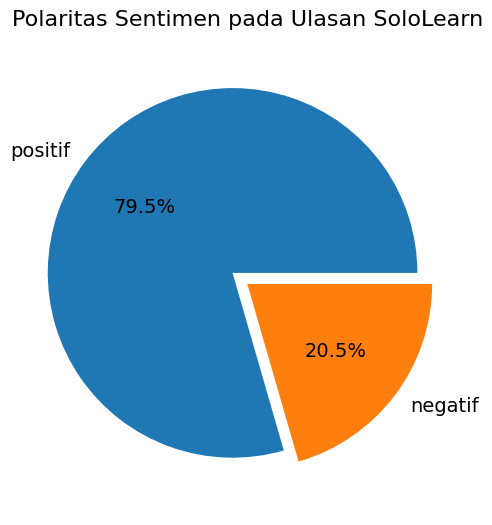

In [56]:
df_sololearn = df[df['Aplikasi'] == 'SoloLearn']
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df_coursera' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df_sololearn['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df_sololearn' dan menyimpannya dalam list 'labels'.
labels = list(df_sololearn['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = [0.1] + [0] * (len(sizes) - 1)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Polaritas Sentimen pada Ulasan SoloLearn', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

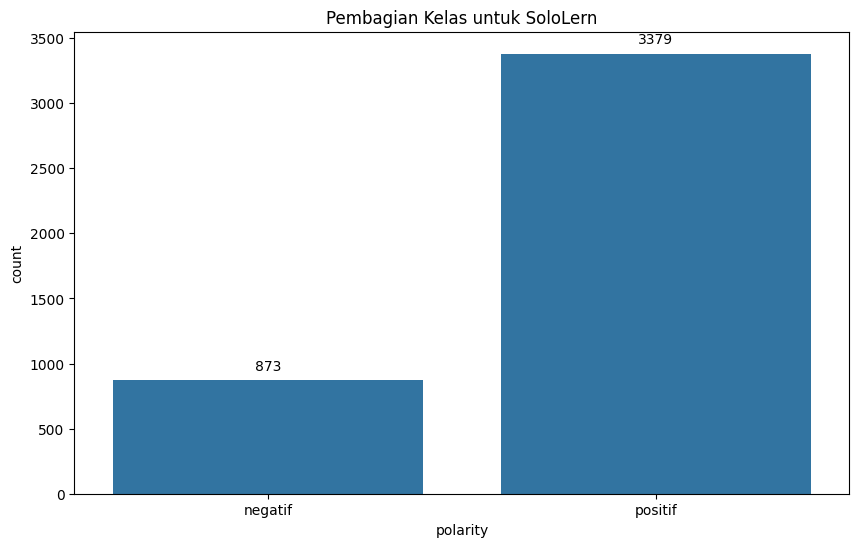

In [57]:
plt.figure(figsize=(10, 6))

# Plot class distribution for Ruang Guru
class_dist_plot = sns.countplot(x='polarity', data=df_sololearn)
plt.title('Pembagian Kelas untuk SoloLern')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

# Show the plot
plt.show()

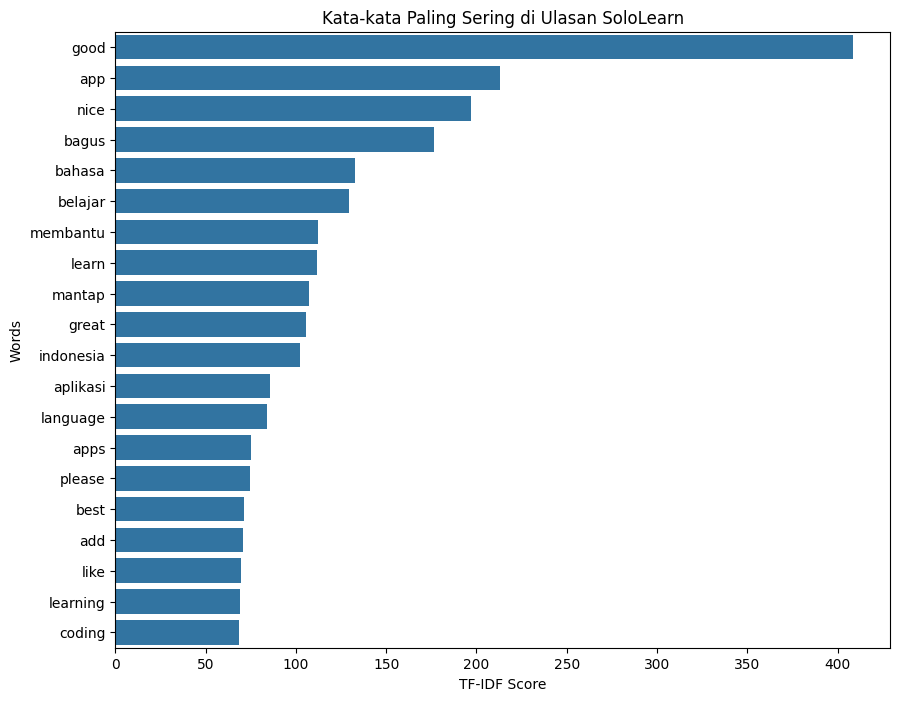

In [58]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_sololearn['text_akhir'])

# Convert to DataFrame and sum up the TF-IDF scores for each word
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')

# Sort by the most frequent words and take the top 20
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Plot the most frequent words
plt.figure(figsize=(10, 8))
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata-kata Paling Sering di Ulasan SoloLearn')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

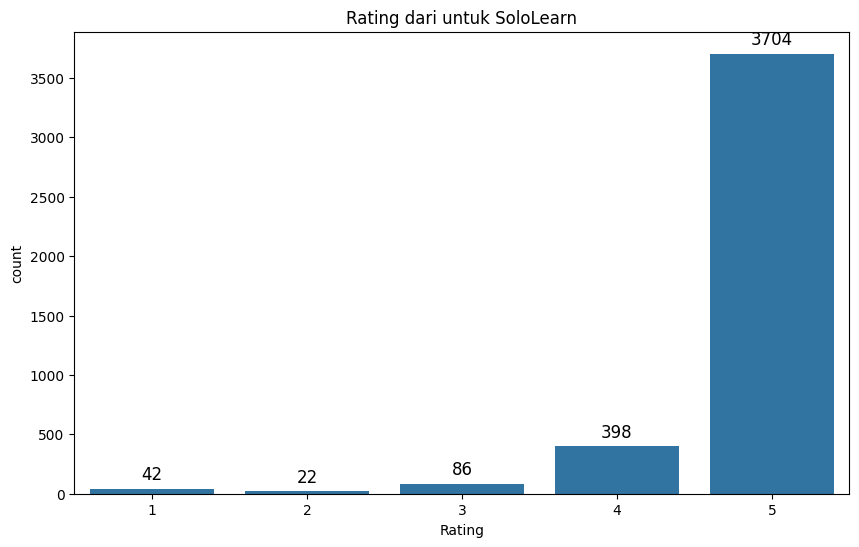

In [59]:
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=df_sololearn)

# Menambahkan angka di atas setiap batang
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                       textcoords='offset points')

# Menambahkan judul
plt.title('Rating dari untuk SoloLearn')

# Menampilkan plot
plt.show()

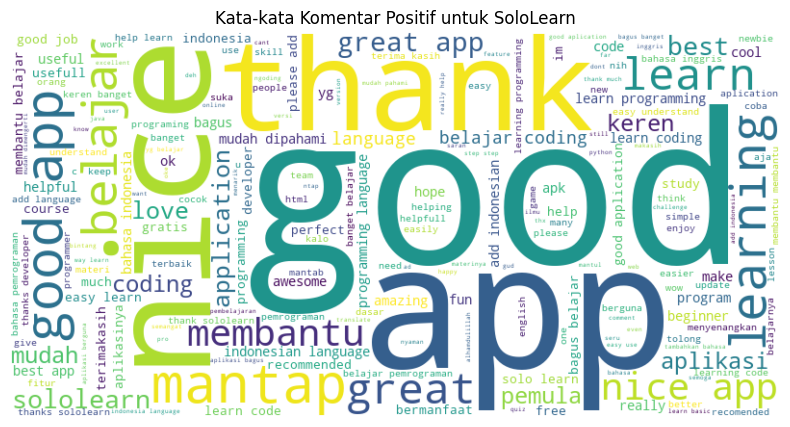

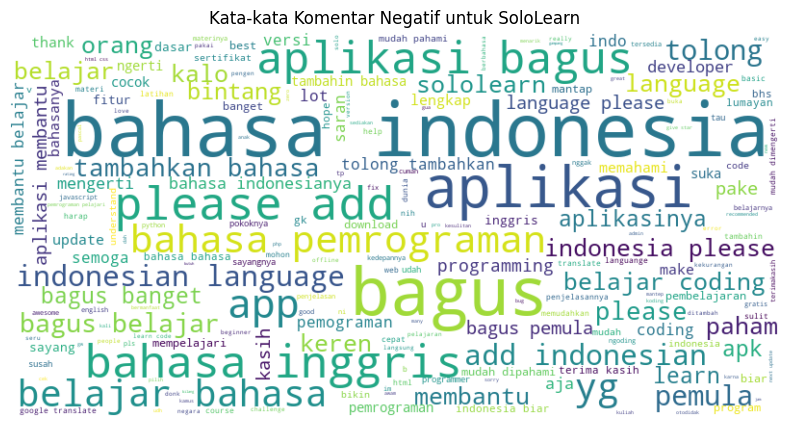

In [60]:
# Nama kolom teks dan polaritas
text_column = 'text_akhir'
polarity_column = 'polarity'
app = 'SoloLearn'
df_sololearn = df[df['Aplikasi'].str.lower() == app.lower()]
if text_column in df_sololearn.columns and polarity_column in df_sololearn.columns:
    # Filter teks positif dan negatif
    positive_texts = " ".join(df_sololearn[df_sololearn[polarity_column] == 'positif'][text_column].tolist())
    negative_texts = " ".join(df_sololearn[df_sololearn[polarity_column] == 'negatif'][text_column].tolist())

    # Membuat word cloud untuk teks positif
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Kata-kata Komentar Positif untuk SoloLearn')
    plt.axis('off')
    plt.show()

    # Membuat word cloud untuk teks negatif
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Kata-kata Komentar Negatif untuk SoloLearn')
    plt.axis('off')
    plt.show()

#### 6.Simplilearn

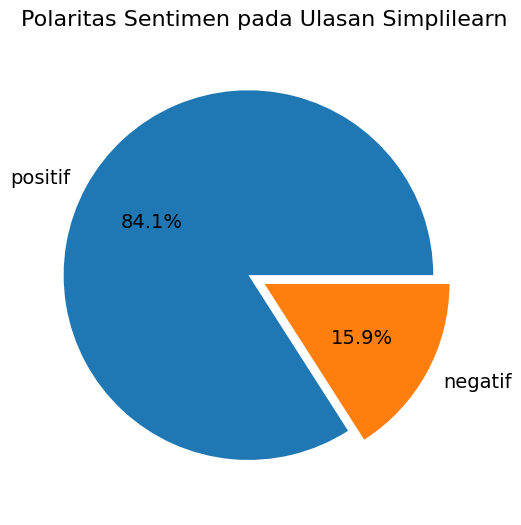

In [61]:
df_simplilearn = df[df['Aplikasi'] == 'Simplilearn']
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df_coursera' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df_simplilearn['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df_simplilearn' dan menyimpannya dalam list 'labels'.
labels = list(df_simplilearn['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = [0.1] + [0] * (len(sizes) - 1)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Polaritas Sentimen pada Ulasan Simplilearn', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

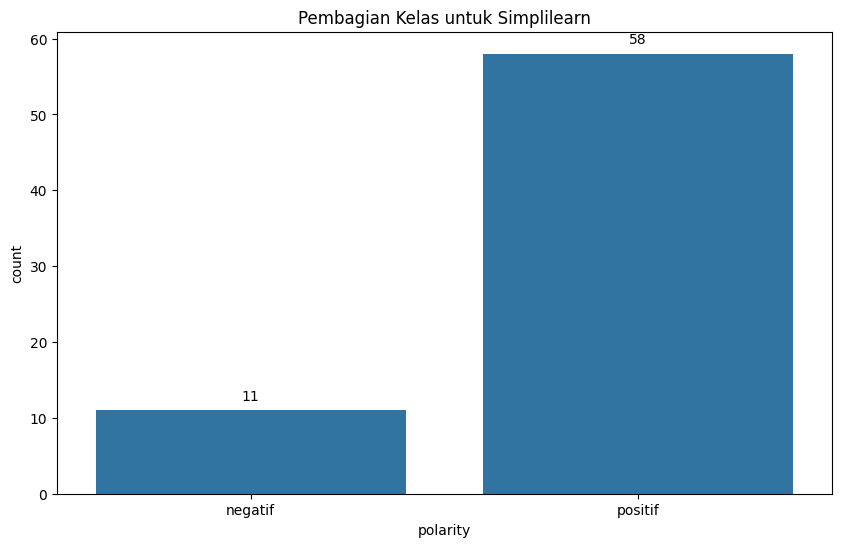

In [62]:
plt.figure(figsize=(10, 6))

# Plot class distribution for Ruang Guru
class_dist_plot = sns.countplot(x='polarity', data=df_simplilearn)
plt.title('Pembagian Kelas untuk Simplilearn')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

# Show the plot
plt.show()

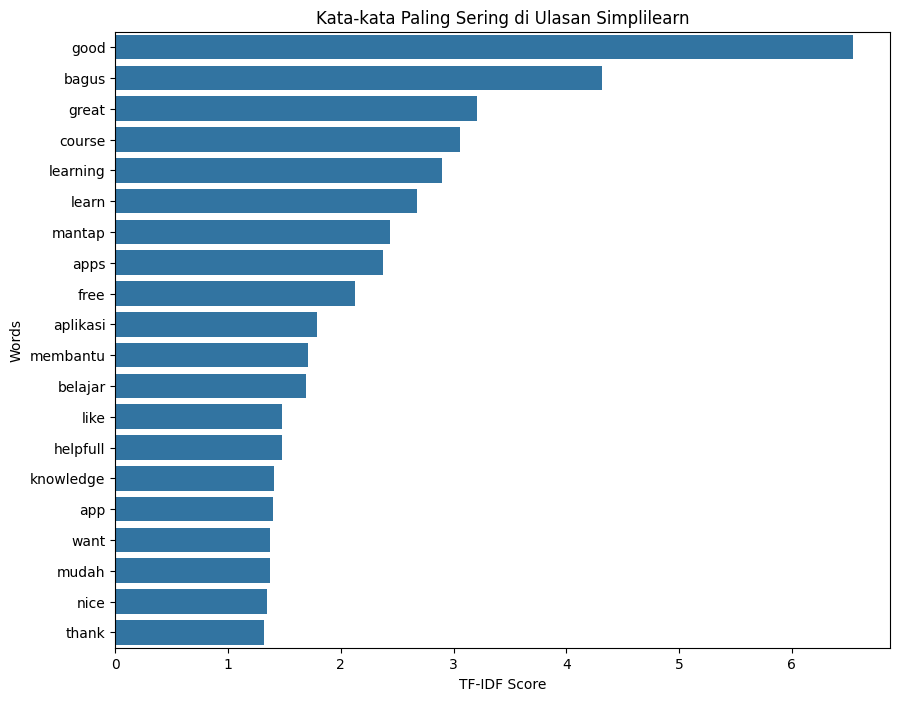

In [63]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_simplilearn['text_akhir'])

# Convert to DataFrame and sum up the TF-IDF scores for each word
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')

# Sort by the most frequent words and take the top 20
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Plot the most frequent words
plt.figure(figsize=(10, 8))
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata-kata Paling Sering di Ulasan Simplilearn')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

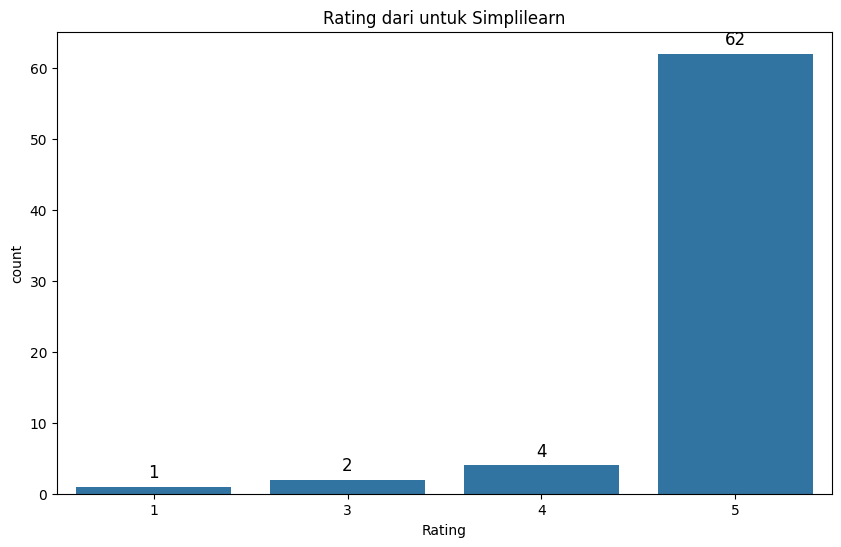

In [64]:
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=df_simplilearn)

# Menambahkan angka di atas setiap batang
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                       textcoords='offset points')

# Menambahkan judul
plt.title('Rating dari untuk Simplilearn')

# Menampilkan plot
plt.show()

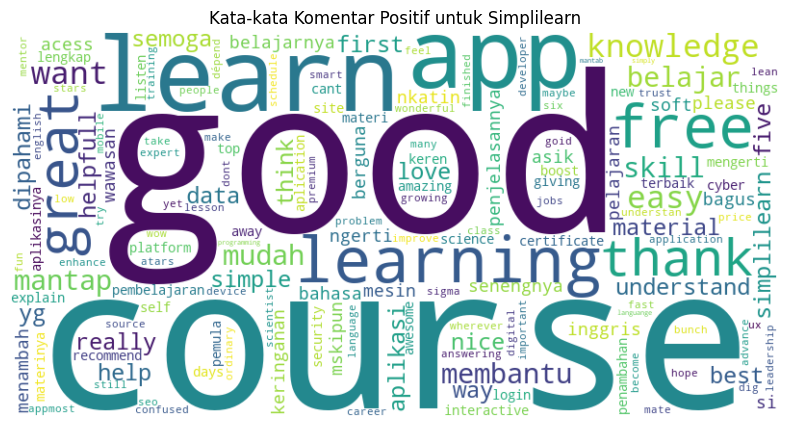

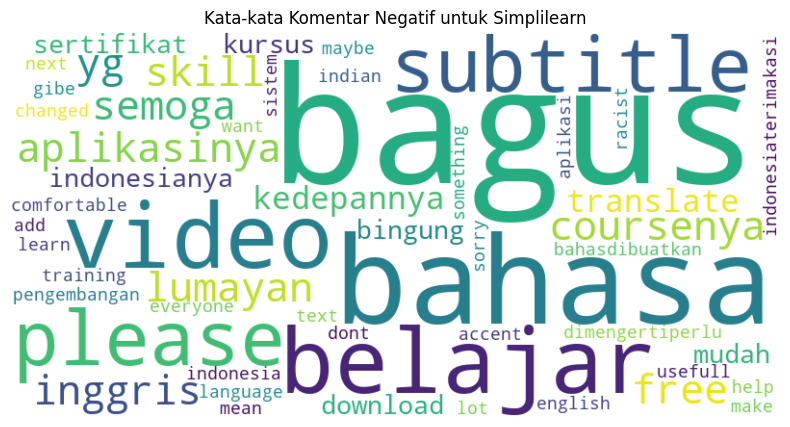

In [65]:
# Nama kolom teks dan polaritas
text_column = 'text_akhir'
polarity_column = 'polarity'
app = 'Simplilearn'
df_simplilearn = df[df['Aplikasi'].str.lower() == app.lower()]
if text_column in df_simplilearn.columns and polarity_column in df_simplilearn.columns:
    # Filter teks positif dan negatif
    positive_texts = " ".join(df_simplilearn[df_simplilearn[polarity_column] == 'positif'][text_column].tolist())
    negative_texts = " ".join(df_simplilearn[df_simplilearn[polarity_column] == 'negatif'][text_column].tolist())

    # Membuat word cloud untuk teks positif
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Kata-kata Komentar Positif untuk Simplilearn')
    plt.axis('off')
    plt.show()

    # Membuat word cloud untuk teks negatif
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Kata-kata Komentar Negatif untuk Simplilearn')
    plt.axis('off')
    plt.show()

### Setiap Evaluasi

#### 1.Navie Bayes

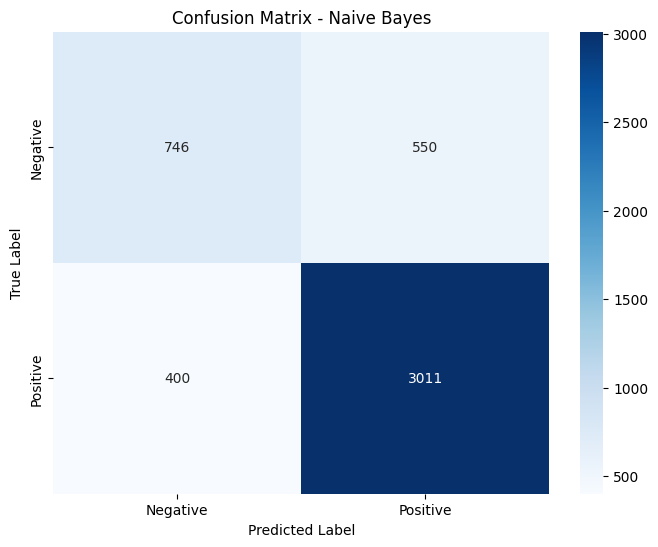

In [65]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

#### 2.Support Vector Machine

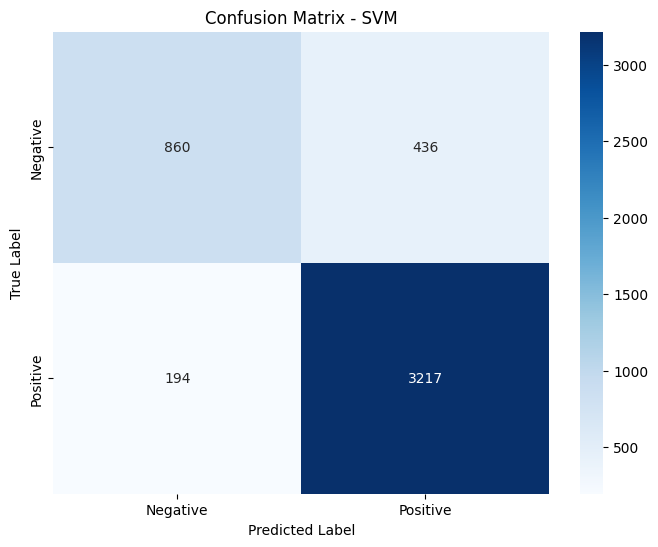

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.show()

#### 3.Decision Tree

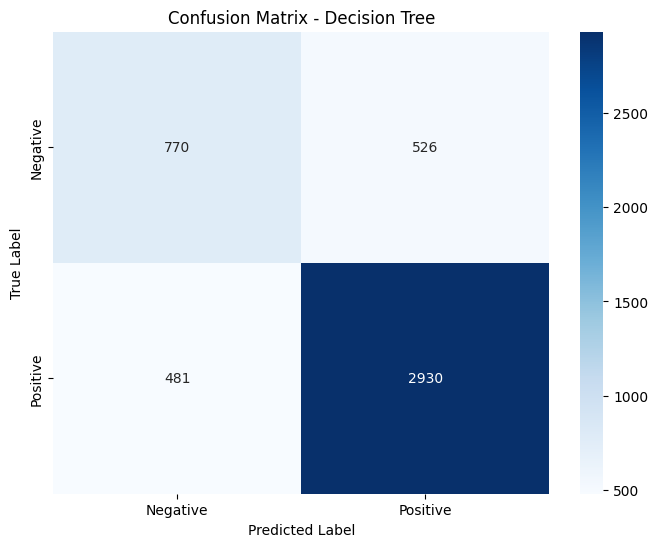

In [67]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

#### 4.Logistic Regression

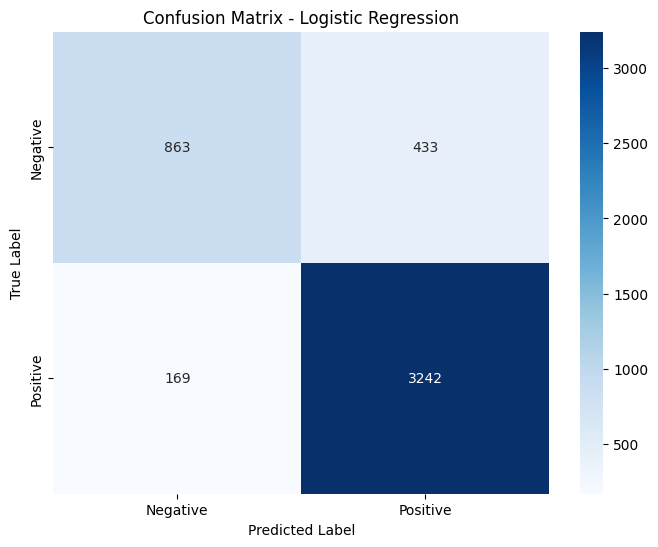

In [68]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### 5.K-Nearest Neighbors

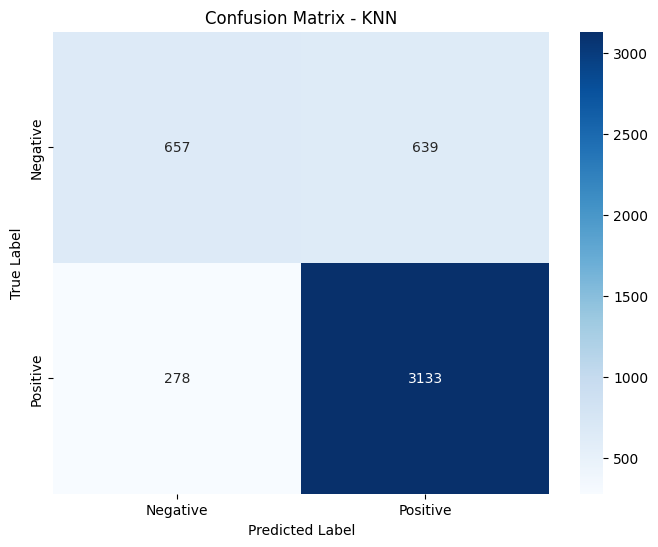

In [69]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN')
plt.show()

#### 6.Xgboost

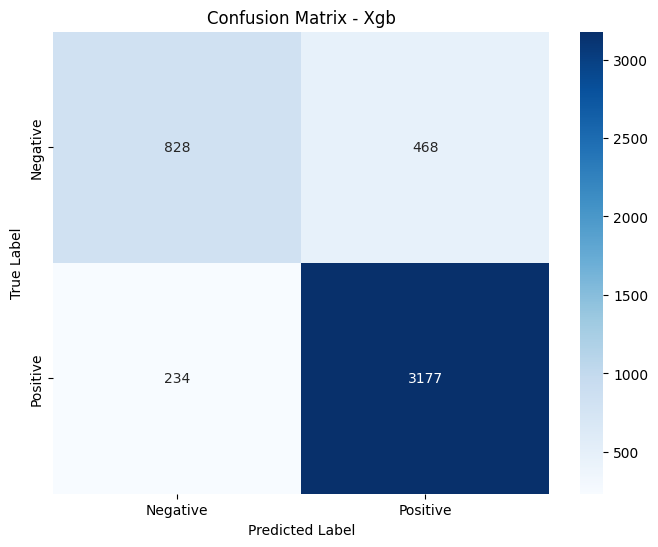

In [70]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Xgb')
plt.show()